https://pymzml.readthedocs.io/en/latest/pymzml_spec.html

In [1]:
import pymzml
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import pyteomics
from pyteomics import mzml, auxiliary
import matplotlib.pyplot as plt
import numpy as np
import math
import plotly.graph_objects as go
import re
from scipy.integrate import simps
import pandas as pd

import peakutils
from peakutils.plot import plot as pplot

In [2]:
path = 'D:/UW/directproject/example_data/20191210_MSpos_tl_frac_B7_F5_narrow_2_noSPE.mzML'

In [3]:
def get_scans(path, ms_lv = 1):
    run = pymzml.run.Reader(path)
    scans = []
    for scan in run:
        if scan.ms_level == ms_lv:
            scans.append(scan)
    return scans

In [4]:
scans = get_scans(path)

In [5]:
#Noise removal
def noise_removal(mzml_scans, int_thres = 5000):
    '''
    the output will overwrite the original mzml file
    '''
    for scan in mzml_scans:
        drop_index = np.argwhere(scan.i <= int_thres)
        scan.i = np.delete(scan.i, drop_index)
        scan.mz = np.delete(scan.mz, drop_index)
    
    return

In [6]:
noise_removal(scans, 1000)

In [7]:
#TIC plot
def tic_plot(mzml_scans, interactive=True):
    '''
    Static tic plot function
    '''
    time=[]
    TIC=[]
    for scan in mzml_scans:
        time.append(scan.scan_time[0])
        TIC.append(scan.TIC)
    
    if interactive == True:
        fig = go.Figure([go.Scatter(x=time, y=TIC,
                        hovertemplate = 'Int: %{y}' + '<br>RT: %{x}minute<br>')])

        fig.update_layout(
            template = 'simple_white',
            width = 1000,
            height = 600,
            xaxis = {'title':'Retention Time (min)'},
            yaxis = dict(
                showexponent = 'all',
                exponentformat = 'e',
                title = 'Intensity'))

        fig.show()
    
    elif interactive == False:
        plt.figure(figsize=(10,6))
        plt.plot(time,TIC)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.xlabel('RT (min)')
        plt.ylabel('TIC')
        plt.title('TIC spectrum')
        plt.show()
    
    return

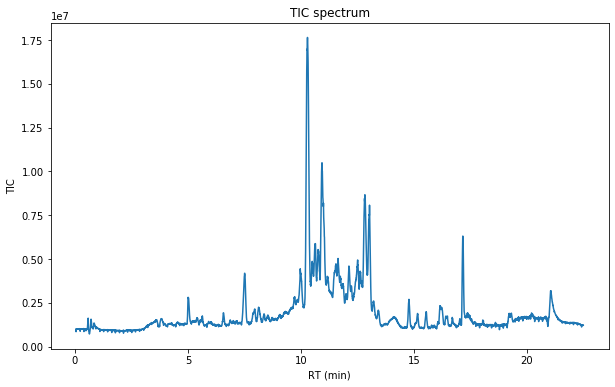

In [8]:
tic_plot(scans,False)

In [9]:
def ms_plot(mzml_scans, time, interactive=False):
    '''
    Interactive spectrum plot with nearest retention time from the given time
    '''
    for scan in mzml_scans:
        if scan.scan_time[0] >= time:
            mz = scan.mz
            ints = scan.i
            rt = scan.scan_time[0]
            break
    
    if interactive == True:        
        fig = go.Figure([go.Bar(x=mz, y=ints, marker_color = 'red', width = 0.5,
                        hovertemplate =
                        'Int: %{y}'+
                        '<br>m/z: %{x}<br>')])
        fig.update_layout(
                title_text=str(round(rt, 3)) + ' min MS1 spectrum, input '+ str(time) + ' min',
                template = 'simple_white',
                width = 1000,
                height = 600,
                xaxis = {'title':'m/z ratio'},
                yaxis = dict(
                    showexponent = 'all',
                    exponentformat = 'e',
                    title = 'Intensity'))
        fig.show()
    
    elif interactive == False:
        plt.figure(figsize=(10,5))
        plt.bar(mz, ints, width = 1.0)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.xlabel('m/z')
        plt.ylabel('Intensity')
        plt.title('MS1 spectrum')
    
    return

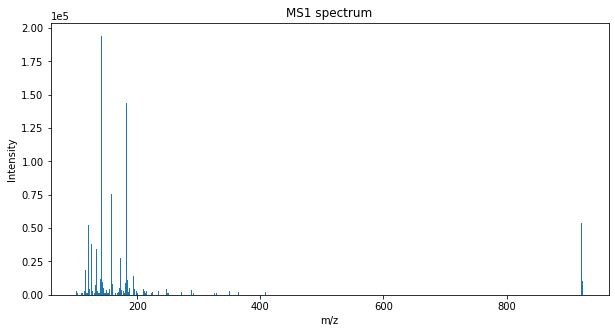

In [10]:
ms_plot(scans, 22, False)

In [11]:
def mz_locator(input_list, mz, error):
    '''
    Find specific mzs from given mz and error range
    input list: mz list
    '''
    target_mz = []
    target_index = []
    
    lower_mz = mz - error
    higher_mz = mz + error

    for i, mzs in enumerate(input_list):
        if mzs < lower_mz:
            continue
        elif mzs >= lower_mz:
            if mzs <= higher_mz:
                target_mz.append(mzs)
                target_index.append(i)
        elif mzs > higher_mz:
                target_mz = 0
                target_index = 'NA'
                break
        
    return target_mz, target_index

In [12]:
def formula_mass(input_formula, mode = 'pos'):
    '''
    sudo code:
    convert input string into a list with element:number structure
    convert all the element into upper case
    match the string list into a given list of element weight
    add adduct/delete H according to mode -- also have neutral mode
    '''
    #Define a list
    elist = {'C': 12, 
            'H':1.00782,
            'N':14.0031,
            'O':15.9949,
            'S':31.9721,
            'P':30.973763,
            'e':0.0005485799}
    
    mol_weight = 0
    parsed_formula = re.findall(r'([A-Z][a-z]*)(\d*)', input_formula)
    for element_count in parsed_formula:
        element = element_count[0]
        count = element_count[1]
        if count == '':
            count = 1
        
        mol_weight += elist[element]*float(count)
    
    if mode == 'pos':
        mol_weight += elist['e'] + elist['H']
    elif mode == 'neg':
        mol_weight -= elist['e'] + elist['H']
    else:
        pass
    
    return mol_weight

In [13]:
def ms_chromatogram(mzml_scans, input_mz, error, smooth=False, mode='pos', interactive=True):
    '''
    Interactive chromatogram for selected m/z
    '''
    if type(input_mz) == float:
        pass
    elif type(input_mz) == int:
        pass
    elif type(input_mz) == str:
        input_mz = formula_mass(input_mz, mode)
    else:
        print('Cant recognize input type!')
    
    print(round(input_mz,3))
    
    
    
    retention_time = []
    intensity = []
    for scan in mzml_scans:
        #print(i)
        retention_time.append(scan.scan_time[0])
        
        target_mz, target_index = mz_locator(scan.mz, input_mz, error)
        if target_index == 'NA':
            intensity.append(0)
        else:
            intensity.append(sum(scan.i[target_index]))

    def peak_smooth(input_list, baseline=500):
        for i, int_ in enumerate(input_list):
            if i > 1 and i < len(input_list)-3:
                if int_ > baseline:
                    for index in np.arange(i+1,i+3):
                        if input_list[index] == 0:
                            input_list[index] = (input_list[index-1]+input_list[index+1])/2
                        else:
                            continue
            
    if smooth == True:
        peak_smooth(intensity)

    if interactive == True:
        fig = go.Figure([go.Scatter(x=retention_time, y=intensity,
                    hovertemplate = 'Int: %{y}' + '<br>RT: %{x}minute<br>')])

        fig.update_layout(
            title_text=str(round(input_mz, 2)) + ' chromatogram, error '+ str(error),
            template = 'simple_white',
            width = 1000,
            height = 600,
            xaxis = {'title':'Retention Time (min)'},
            yaxis = dict(
                showexponent = 'all',
                exponentformat = 'e',
                title = 'Intensity'))

        fig.show()
    elif interactive == False:
        plt.figure(figsize=(20,10))
        plt.plot(retention_time, intensity)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.xlabel('m/z')
        plt.ylabel('Intensity')
        plt.title('MS1 spectrum')
        plt.xlim(0,retention_time[-1])
        plt.ylim(0,)
        plt.show()
    return

299.176


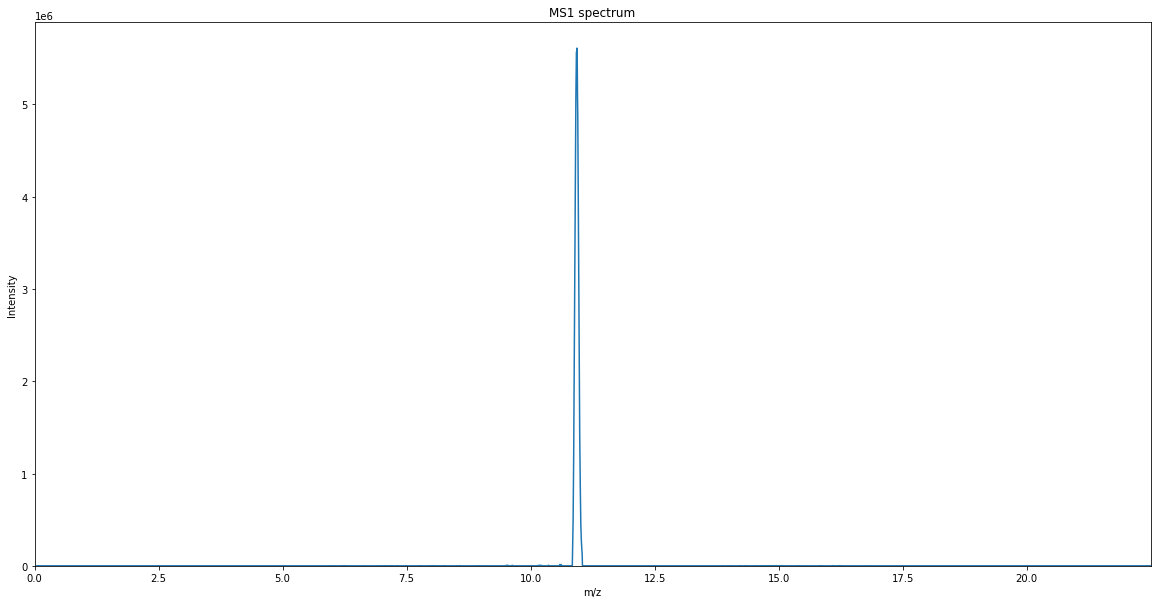

In [14]:
ms_chromatogram(scans, 'C18H22N2O2', 0.002, False, 'pos',False)

In [15]:
#Deal with roi, check peakonly
def peak_pick(mzml_scans, input_mz, error, peak_base = 5000, thr = 0.02, min_d = 1, rt_window = 1.5, peak_area_thres = 1e5, min_scan = 15, max_scan = 200, max_peak = 7):
    '''
    rt, ints from ms_chromatogram_list
    rt_window now set up for minutes
    '''
    
    #Important funciont, may need to be extracted out later
    def ms_chromatogram_list(mzml_scans, input_mz, error):
        '''
        Generate a peak list for specific input_mz over whole rt period from the mzml file
        ***Most useful function!
        '''
        retention_time = []
        intensity = []
        for scan in mzml_scans:
            #print(i)
            retention_time.append(scan.scan_time[0])

            target_mz, target_index = mz_locator(scan.mz, input_mz, error)
            if target_index == 'NA':
                intensity.append(0)
            else:
                intensity.append(sum(scan.i[target_index]))
            
        return retention_time, intensity
    
    rt, intensity = ms_chromatogram_list(mzml_scans, input_mz, error)
    
    #Get rt_window corresponded scan number
    scan_window = int((rt_window / (rt[int(len(intensity) / 2)] - rt[int(len(intensity) / 2) - 1])) / 2)
    
    #Get peak index
    indexes = peakutils.indexes(intensity, thres=thr, min_dist = min_d)
    
    result_dict = {}
    
    for index in indexes:
        h_range = index
        l_range = index
        base_intensity = peak_base

        #Get the higher and lower boundary
        while intensity[h_range] >= base_intensity:
            h_range += 1
            if h_range > len(intensity)-2:
                break
        while intensity[l_range] >= base_intensity:
            l_range -= 1
        #Output a range from the peak list
        
        peak_range = []
        if h_range - l_range >= min_scan:
            if rt[h_range] - rt[l_range] <= rt_window:
                peak_range = intensity[l_range:h_range]
            else:
                l_range = index - scan_window
                h_range = index + scan_window
                peak_range = intensity[l_range:h_range]
                #print(index + scan_window)

        #Intergration based on the simps function
        if len(peak_range) >= min_scan:
            integration_result = simps(peak_range)
            if integration_result >= peak_area_thres:
                if len(result_dict) == 0:
                    result_dict.update({index : [l_range, h_range, integration_result]})
                elif integration_result != list(result_dict.values())[-1][2]: #Compare with previous item
                    result_dict.update({index : [l_range, h_range, integration_result]})
                
        #Filtering:
        #1. delete results that l_range/h_range within 5 scans
        #3. If still >5 then select top 5 results
        #list(result_dict.values())[-1]
    
    #Noise filter
    if len(result_dict) > max_peak:
        result_dict = {}
        


    return result_dict

In [16]:
test_dict = peak_pick(scans, 299.5, 0.5)

In [17]:
test_dict

{1971: [1881, 2111, 102785039.67763263], 2187: [2113, 2302, 9271622.19897461]}

In [18]:
def integration_plot(mzml_scans, input_mz, error, peak_base = 0.005, thr = 0.02, min_d = 1, rt_window = 2, peak_area_thres = 1e5):
    
    result_dict = peak_pick(mzml_scans, input_mz, error)
    
    def ms_chromatogram_list(mzml_scans, input_mz, error):
        '''
        Generate a peak list for specific input_mz over whole rt period from the mzml file
        ***Most useful function!
        '''
        retention_time = []
        intensity = []
        for scan in mzml_scans:
            #print(i)
            retention_time.append(scan.scan_time[0])

            target_mz, target_index = mz_locator(scan.mz, input_mz, error)
            if target_index == 'NA':
                intensity.append(0)
            else:
                intensity.append(sum(scan.i[target_index]))

        return retention_time, intensity

    rt, ints = ms_chromatogram_list(mzml_scans, input_mz, error)
    
    plt.figure(figsize=(20,10))
    plt.plot(rt, ints)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlabel('m/z')
    plt.ylabel('Intensity')
    plt.title('Integration result')
    plt.xlim(0,rt[-1])
    plt.ylim(0,)
    
    for index in result_dict:
        print('Peak retention time: {:0.2f} minute, Peak area: {:0.1f}'.format(rt[index], result_dict[index][2]))
        plt.fill_between(rt[result_dict[index][0] : result_dict[index][1]], ints[result_dict[index][0] : result_dict[index][1]])
        
    
    return

Peak retention time: 10.94 minute, Peak area: 102785039.7
Peak retention time: 12.13 minute, Peak area: 9271622.2


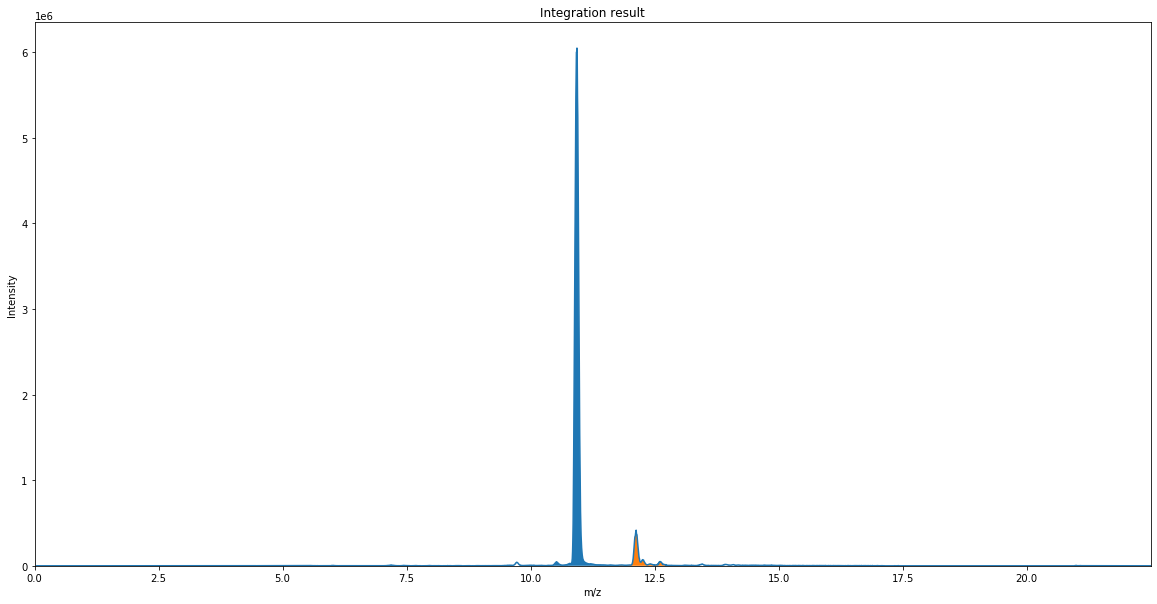

In [19]:
integration_plot(scans, 299.5, 0.5)

In [40]:
#Main dev issue--iteration efficiency & peak picking algorithm update
#2way: 1. optimize iteration algorithm, 2. optimize mz_list selection--drop useless mzs
def peak_list(mzml_scans, mz_error, mzmin = 0, mzmax=1000, peak_base = 0.005, thr = 0.02, min_d = 1, rt_window = 1.5, peak_area_thres = 1e5, min_scan = 7, scan_thres = 7):
    '''
    input from ms1_baseline function
    Q to solve: how to correctly select mz slice?? see mz_locator
    '''
    
    #Get m/z range
    def mz_array(scans, mz_error):
        min_mz = scans[0].mz.min()
        max_mz = scans[0].mz.max()
        for scan in scans:
            if min_mz > scan.mz.min():
                min_mz = scan.mz.min()
            if max_mz < scan.mz.max():
                max_mz = scan.mz.max()

        mz_list = np.arange(min_mz + mz_error, max_mz - mz_error,2 * mz_error)

        return mz_list
    
    mzlist = mz_array(mzml_scans, mz_error)
    
    if mzlist.max() >= mzmax:
        mzlist = mzlist[mzlist <= mzmax]
    if mzlist.min() <= mzmin:
        mzlist = mzlist[mzlist >= mzmin]
    
    
    result_dict = {}
    rt = []
    for scan in mzml_scans:
        rt.append(scan.scan_time[0])
    
    for mz in tqdm(mzlist):
        try:
            peak_dict = peak_pick(mzml_scans, mz, mz_error)
        except:
            pass
        
        if len(peak_dict) != 0:
            if len(result_dict) == 0:
                for index in peak_dict:
                    result_dict.update({'m/z' : [mz],
                                        'rt' : [rt[index]],
                                        'peak area' : [peak_dict[index][2]]})
            else:
                for index in peak_dict:
                    result_dict['m/z'].append(mz)
                    result_dict['rt'].append(rt[index])
                    result_dict['peak area'].append(peak_dict[index][2])
            
    print('Peak processing finished!')
    d_result = pd.DataFrame(result_dict)
    d_result['rt'] = round(d_result['rt'], 2)
    d_result['m/z'] = round(d_result['m/z'], 4)
    print('Dataframe created!')
    
    return 

In [33]:
d_test = peak_list(scans, 0.002, 298.5, 300)

100%|██████████| 375/375 [02:04<00:00,  3.01it/s]


Peak processing finished!
Dataframe created!


In [34]:
d_test

,m/z,rt,peak area
0,299.1763,10.94,9.213508e+07
1,299.2003,12.01,2.168725e+06
2,299.2003,12.20,1.207414e+06
3,299.3243,10.94,6.580618e+06


Peak retention time: 10.94 minute, Peak area: 6580617.9


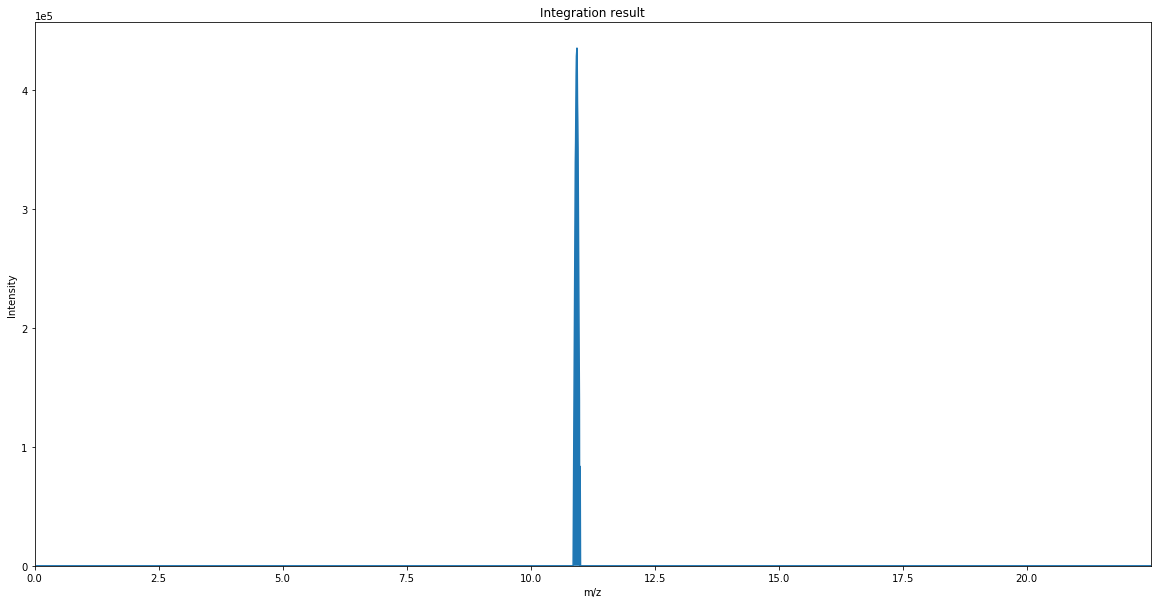

In [37]:
integration_plot(scans, 299.3243, 0.002)